<a href="https://colab.research.google.com/github/micdist/fast.ai/blob/main/bestPastaYet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -U fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.5MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 1.2MB 50.8MB/s 
     |████████████████████████████████| 204kB 48.8MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '902511d642d44ccd983cdf8ca50331a3')

In [4]:
search_images_bing

<function fastbook.search_images_bing>

In [5]:
results = search_images_bing(key, 'pasta corta')
ims = results.attrgot('content_url')
len(ims)

150

In [6]:
#rimpiazzare con immagine pasta
ims = ['https://blog.giallozafferano.it/allyoucancook/wp-content/uploads/2016/08/pasta-corta.jpg']

In [7]:
dest = 'images/pasta.jpg'
download_url(ims[0], dest)

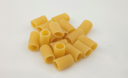

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

In [102]:
os.path.abspath('images')   

'/content/images'

In [103]:
#sostituire orsi con pasta
pasta_types = 'corta','lunga'
path = Path('pasta')

In [12]:
#search for all 2 kinds of pasta from bing
if not path.exists() :
    path.mkdir()
    for o in pasta_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key,f'pasta {o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [104]:
fns = get_image_files(path)
fns

(#249) [Path('pasta/corta/00000035.jpg'),Path('pasta/corta/00000079.jpg'),Path('pasta/corta/00000114.jpg'),Path('pasta/corta/00000058.jpg'),Path('pasta/corta/00000042.jpg'),Path('pasta/corta/00000077.jpg'),Path('pasta/corta/00000066.jpg'),Path('pasta/corta/00000095.jpg'),Path('pasta/corta/00000015.png'),Path('pasta/corta/00000000.jpg')...]

In [105]:
#verify existance of corrupted images
failed = verify_images(fns)
failed

(#0) []

In [15]:
#verify_images returns an object of type L, which includes the map method
failed.map(Path.unlink);

In [106]:
pasta = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [107]:
#creazione dataLoader
dls = pasta.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


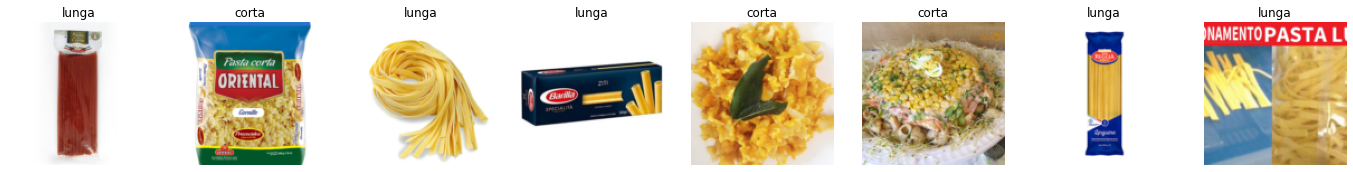

In [108]:
dls.valid.show_batch(max_n=8, nrows=1)

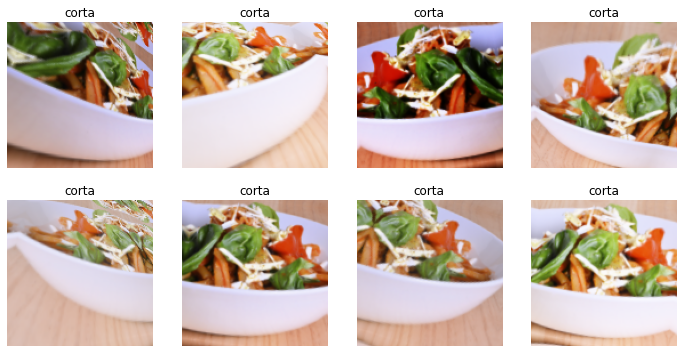

In [19]:
#data augmentation

#item transform: one image at the time
#batch transform: batch of images at time -> augmentation on batch

pasta = pasta.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = pasta.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [109]:
pasta = pasta.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pasta.dataloaders(path)

In [110]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


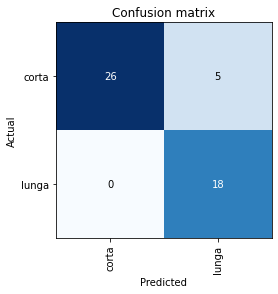

In [111]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

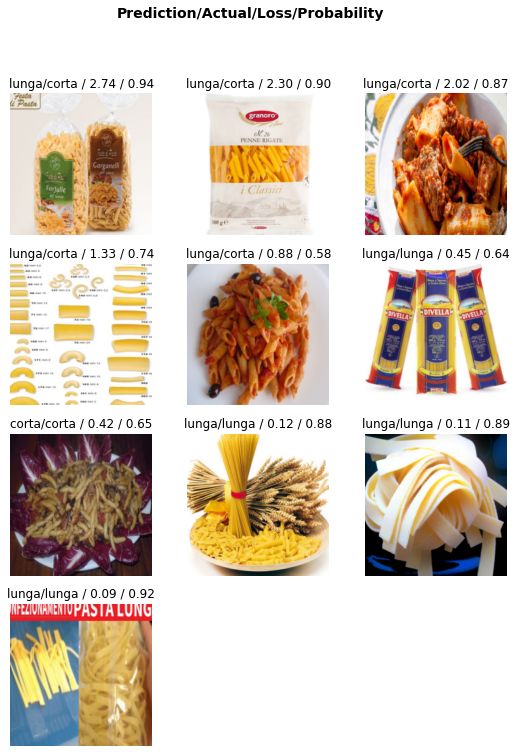

In [112]:
interp.plot_top_losses(10, nrows=4)

In [ ]:
?ImageClassifierCleaner()

In [113]:
#cleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [115]:
#elimina delete
for idx in cleaner.delete(): cleaner.fns[idx].unlink()


In [43]:
#quello che segue sposta le immagini
for idx in cleaner.delete(): cleaner.fns.remove(cleaner.fns[idx])

In [ ]:
#rinomina file spostati aggiungendo * al nome
for idx,cat in cleaner.change(): 
    try:
        shutil.move(str(cleaner.fns[idx]), path/cat)
    except Exception as e:
        print(e)
        originalfn = str(cleaner.fns[idx]).split('/')[-1] 
        ext = originalfn.split('.')[-1]
        newFn = originalfn[:-len(ext)-1]
        shutil.move(Path(str(path/cat)+'/' +str(originalfn)), str(Path(str(path/cat) + ('/'+ newFn + '_'+ '*' + '.'+ext))))
        shutil.move(str(cleaner.fns[idx]), path/cat)

In [116]:
#reload data
pasta = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [117]:
pasta = pasta.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pasta.dataloaders(path)

In [118]:
#creazione dataLoader
dls = pasta.dataloaders(path)

In [119]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


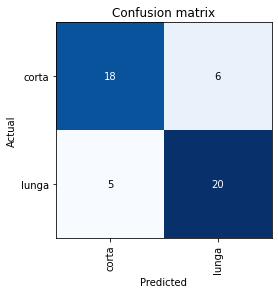

In [120]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

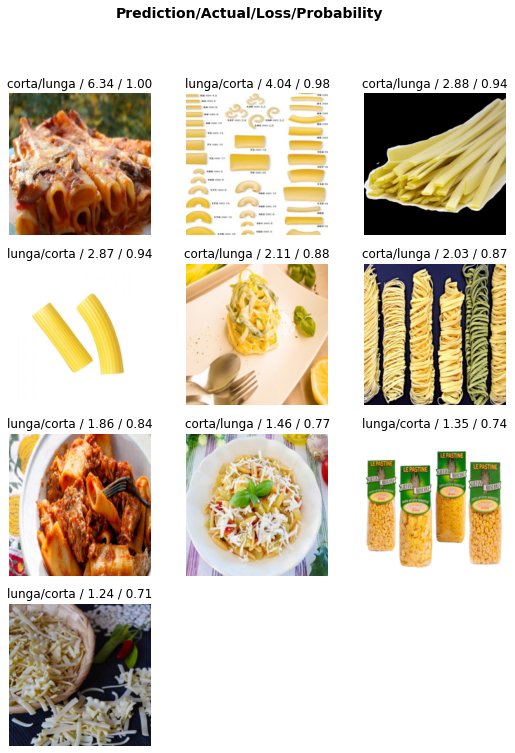

In [121]:
interp.plot_top_losses(10, nrows=4)

**INFERENCE**

In [126]:
#using model for inference

learn.export()

In [127]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [128]:
#to create inference learner from exported model

learn_inf = load_learner(path/'export.pkl')

In [129]:

#pass a file to
#immagineTestInf = ['https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRoPLEwVcvGAptMT0OTeq4CYpGsCkQI2A8bkQ&usqp=CAU']
immagineTestInf =['https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTVqf0S8Kt3AZGjVSwdEM9e9lIT9KaDD-x0AA&usqp=CAU']
#cambiare il nome di test altrimenti lavora sempre sulla stessa immagine
dest = 'images/test0.jpg'

download_url(immagineTestInf[0],dest)

#actual inference
learn_inf.predict(dest)

('corta', tensor(0), tensor([0.9511, 0.0489]))

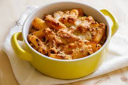

In [130]:
im = Image.open(dest)
im.to_thumb(128,128)

**GUI for INFERENCE**

In [131]:
#button upload image
btn_upload = widgets.FileUpload()
btn_upload 

FileUpload(value={}, description='Upload')

In [132]:
img = PILImage.create(btn_upload.data[-1])

In [133]:
#output widget to display the loaded pic
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(256,256))
out_pl

Output()

In [71]:
#make the prediction
pred,pred_idx,probs = learn_inf.predict(img)

In [134]:
#use a Label to display prediction made
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
#lbl_pred.value = f'Prediction: {""}; Probability: {probs[0]:.0f}'
lbl_pred

Label(value='Prediction: ; Probability: 0')

In [90]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [91]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.14f}'

btn_run.on_click(on_click_classify)

In [135]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [136]:
#hide_output
VBox([widgets.Label('Upload your pasta'), 
      btn_upload, btn_run, out_pl, lbl_pred])

trovare codice essenziale, possibilmente salvare learn, far funzionare voilà con colab